# Online retail analysis using Eland

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/elastic/eland/blob/main/docs/sphinx/examples/online_retail_analysis.ipynb)

Learn how to analyze some online retail data using Eland.

## Install and import packages

In [9]:
!!pip install eland, elasticsearch

from elasticsearch import Elasticsearch
import eland as ed
import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fix console size for consistent test results
from eland.conftest import *

## Connect to Elasticsearch

First we need to connect to a running Elasticsearch instance.
In this example we'll be using Elastic Cloud.
Sign up for a [free trial](https://cloud.elastic.co/registration).

See [documentation](https://www.elastic.co/guide/en/elasticsearch/client/python-api/current/connecting.html#connect-self-managed-new) if you want to connect to a self-managed cluster.

In [10]:
# Connect to an Elastic Cloud instance

ELASTIC_CLOUD_ID = getpass.getpass("Cloud ID:")
ELASTIC_CLOUD_PASSWORD = getpass.getpass("`elastic` user password:")

es = Elasticsearch(
  cloud_id=ELASTIC_CLOUD_ID,
  basic_auth=("elastic", ELASTIC_CLOUD_PASSWORD)
)
print(es.info())

Cloud ID:··········
`elastic` user password:··········
{'name': 'instance-0000000001', 'cluster_name': '0e70bcb52e554bcfbd010d4c5ede7cd6', 'cluster_uuid': 'zH6HUJIRRseQ0FmkiPDlww', 'version': {'number': '8.12.0-SNAPSHOT', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'eb62fa806f0d867482991d5d22eec5d28e4e4b34', 'build_date': '2023-11-19T19:22:51.933153245Z', 'build_snapshot': True, 'lucene_version': '9.8.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


## Download test data

Let's start by downloading our test data.

In [17]:
import requests

# URL of the raw file on GitHub
file_url = "https://github.com/elastic/eland/raw/main/docs/sphinx/examples/data/online-retail.csv.gz"

# Local path where you want to save the file
local_filename = "online-retail.csv.gz"

# Send a GET request to the file URL
response = requests.get(file_url, stream=True)

# Open a local file in binary write mode
with open(local_filename, 'wb') as file:
    for chunk in response.iter_content(chunk_size=128):
        file.write(chunk)

print(f"File downloaded: {local_filename}")

File downloaded: online-retail.csv.gz


## Create Eland dataframe

To get started, let's create an `eland.DataFrame` by reading a csv file. This creates and populates the
`online-retail` index in the local Elasticsearch cluster.

In [19]:
df = ed.csv_to_eland("online-retail.csv.gz",
                     es_client=es,
                     es_dest_index='online-retail',
                     es_if_exists='replace',
                     es_dropna=True,
                     es_refresh=True,
                     compression='gzip',
                     index_col=0)

/usr/local/lib/python3.10/dist-packages/eland/etl.py:529: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  reader = pd.read_csv(filepath_or_buffer, **kwargs)
/usr/local/lib/python3.10/dist-packages/eland/etl.py:529: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  reader = pd.read_csv(filepath_or_buffer, **kwargs)


Here we see that the `"_id"` field was used to index our data frame.

In [20]:
df.index.es_index_field

'_id'

Next, we can check which field from elasticsearch are available to our eland data frame. `columns` is available as a parameter when instantiating the data frame which allows one to choose only a subset of fields from your index to be included in the data frame. Since we didn't set this parameter, we have access to all fields.

In [21]:
df.columns

Index(['Country', 'CustomerID', 'Description', 'InvoiceDate', 'InvoiceNo', 'Quantity', 'StockCode',
       'UnitPrice'],
      dtype='object')

Now, let's see the data types of our fields. Running `df.dtypes`, we can see that elasticsearch field types are mapped to pandas field types.

In [22]:
df.dtypes

Country         object
CustomerID     float64
Description     object
InvoiceDate     object
InvoiceNo       object
Quantity         int64
StockCode       object
UnitPrice      float64
dtype: object

We also offer a `.es_info()` data frame method that shows all info about the underlying index. It also contains information about operations being passed from data frame methods to elasticsearch. More on this later.

In [23]:
print(df.es_info())

es_index_pattern: online-retail
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
            es_field_name  is_source es_dtype es_date_format pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
Country           Country       True  keyword           None   object           True             True        False                    Country
CustomerID     CustomerID       True   double           None  float64           True             True        False                 CustomerID
Description   Description       True  keyword           None   object           True             True        False                Description
InvoiceDate   InvoiceDate       True  keyword           None   object           True             True        False                InvoiceDate
InvoiceNo       InvoiceNo       True  keyword           None   object           True             True        False                  InvoiceNo
Quantity         Quantity       True   

## Selecting and Indexing Data

Now that we understand how to create a data frame and get access to it's underlying attributes, let's see how we can select subsets of our data.

### head and tail

much like pandas, eland data frames offer `.head(n)` and `.tail(n)` methods that return the first and last n rows, respectively.

In [24]:
df.head(2)

,Country,CustomerID,...,StockCode,UnitPrice
0,United Kingdom,17850.0,...,85123A,2.55
1,United Kingdom,17850.0,...,71053,3.39


In [25]:
print(df.tail(2).head(2).tail(2).es_info())

es_index_pattern: online-retail
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
            es_field_name  is_source es_dtype es_date_format pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
Country           Country       True  keyword           None   object           True             True        False                    Country
CustomerID     CustomerID       True   double           None  float64           True             True        False                 CustomerID
Description   Description       True  keyword           None   object           True             True        False                Description
InvoiceDate   InvoiceDate       True  keyword           None   object           True             True        False                InvoiceDate
InvoiceNo       InvoiceNo       True  keyword           None   object           True             True        False                  InvoiceNo
Quantity         Quantity       True   

In [26]:
df.tail(2)

,Country,CustomerID,...,StockCode,UnitPrice
14998,United Kingdom,17419.0,...,21773,1.25
14999,United Kingdom,17419.0,...,22149,2.10


### Selecting columns

you can also pass a list of columns to select columns from the data frame in a specified order.

In [27]:
df[['Country', 'InvoiceDate']].head(5)

,Country,InvoiceDate
0,United Kingdom,2010-12-01 08:26:00
1,United Kingdom,2010-12-01 08:26:00
2,United Kingdom,2010-12-01 08:26:00
3,United Kingdom,2010-12-01 08:26:00
4,United Kingdom,2010-12-01 08:26:00


### Boolean Indexing

we also allow you to filter the data frame using boolean indexing. Under the hood, a boolean index maps to a `terms` query that is then passed to elasticsearch to filter the index.

In [28]:
# the construction of a boolean vector maps directly to an elasticsearch query
print(df['Country']=='Germany')
df[(df['Country']=='Germany')].head(5)

{'term': {'Country': 'Germany'}}


,Country,CustomerID,...,StockCode,UnitPrice
1109,Germany,12662.0,...,22809,2.95
1110,Germany,12662.0,...,84347,2.55
1111,Germany,12662.0,...,84945,0.85
1112,Germany,12662.0,...,22242,1.65
1113,Germany,12662.0,...,22244,1.95


we can also filter the data frame using a list of values.

In [29]:
print(df['Country'].isin(['Germany', 'United States']))
df[df['Country'].isin(['Germany', 'United Kingdom'])].head(5)

{'terms': {'Country': ['Germany', 'United States']}}


,Country,CustomerID,...,StockCode,UnitPrice
0,United Kingdom,17850.0,...,85123A,2.55
1,United Kingdom,17850.0,...,71053,3.39
2,United Kingdom,17850.0,...,84406B,2.75
3,United Kingdom,17850.0,...,84029G,3.39
4,United Kingdom,17850.0,...,84029E,3.39


We can also combine boolean vectors to further filter the data frame.

In [30]:
df[(df['Country']=='Germany') & (df['Quantity']>90)]

,Country,CustomerID,...,StockCode,UnitPrice


Using this example, let see how eland translates this boolean filter to an elasticsearch `bool` query.

In [31]:
print(df[(df['Country']=='Germany') & (df['Quantity']>90)].es_info())

es_index_pattern: online-retail
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
            es_field_name  is_source es_dtype es_date_format pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
Country           Country       True  keyword           None   object           True             True        False                    Country
CustomerID     CustomerID       True   double           None  float64           True             True        False                 CustomerID
Description   Description       True  keyword           None   object           True             True        False                Description
InvoiceDate   InvoiceDate       True  keyword           None   object           True             True        False                InvoiceDate
InvoiceNo       InvoiceNo       True  keyword           None   object           True             True        False                  InvoiceNo
Quantity         Quantity       True   

## Aggregation and Descriptive Statistics

Let's begin to ask some questions of our data and use eland to get the answers.

**How many different countries are there?**

In [32]:
df['Country'].nunique()

16

**What is the total sum of products ordered?**

In [33]:
df['Quantity'].sum()

111960

**Show me the sum, mean, min, and max of the qunatity and unit_price fields**

In [34]:
df[['Quantity','UnitPrice']].agg(['sum', 'mean', 'max', 'min'])

,Quantity,UnitPrice
sum,111960.000,61548.490000
mean,7.464,4.103233
max,2880.000,950.990000
min,-9360.000,0.000000


**Give me descriptive statistics for the entire data frame**

In [35]:
# NBVAL_IGNORE_OUTPUT
df.describe()

,CustomerID,Quantity,UnitPrice
count,10729.000000,15000.000000,15000.000000
mean,15590.776680,7.464000,4.103233
std,1764.189592,85.930116,20.106214
min,12347.000000,-9360.000000,0.000000
25%,14225.913815,1.000000,1.336010
50%,15668.124797,2.423796,2.396465
75%,17195.974646,7.403795,4.282239
max,18239.000000,2880.000000,950.990000


**Show me a histogram of numeric columns**

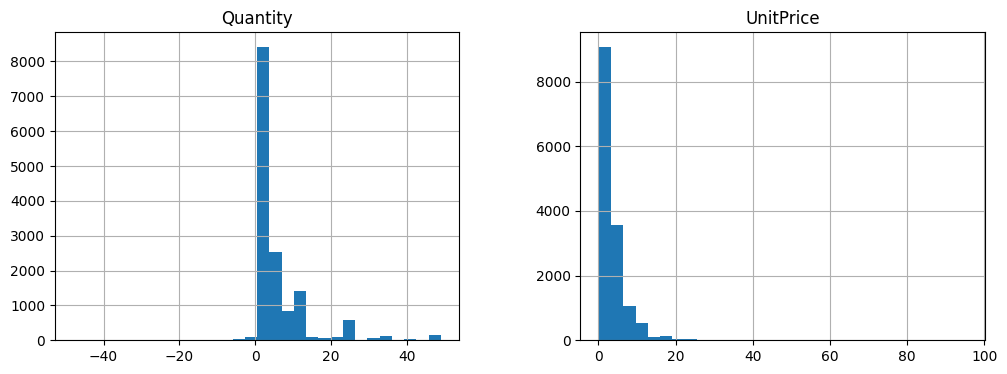

In [36]:
df[(df['Quantity']>-50) &
   (df['Quantity']<50) &
   (df['UnitPrice']>0) &
   (df['UnitPrice']<100)][['Quantity', 'UnitPrice']].hist(figsize=[12,4], bins=30)
plt.show()

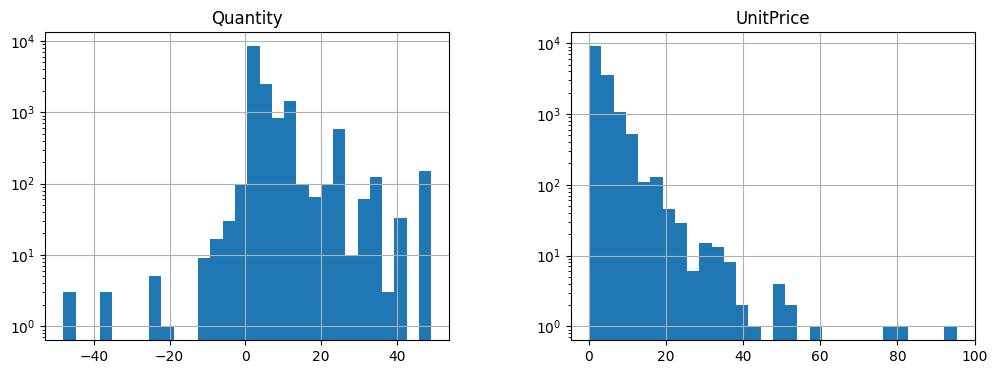

In [37]:
df[(df['Quantity']>-50) &
   (df['Quantity']<50) &
   (df['UnitPrice']>0) &
   (df['UnitPrice']<100)][['Quantity', 'UnitPrice']].hist(figsize=[12,4], bins=30, log=True)
plt.show()

In [46]:
df.query('Quantity>50 & UnitPrice<100')

ValueError: ignored

## Arithmetic Operations

Numeric values

In [41]:
df['Quantity'].head()

0    6
1    6
2    8
3    6
4    6
Name: Quantity, dtype: int64

In [42]:
df['UnitPrice'].head()

0    2.55
1    3.39
2    2.75
3    3.39
4    3.39
Name: UnitPrice, dtype: float64

In [43]:
product = df['Quantity'] * df['UnitPrice']

/usr/local/lib/python3.10/dist-packages/eland/field_mappings.py:715: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._mappings_capabilities = self._mappings_capabilities.append(


In [44]:
product.head()

0    15.30
1    20.34
2    22.00
3    20.34
4    20.34
dtype: float64

String concatenation

In [45]:
df['Country'] + df['StockCode']

/usr/local/lib/python3.10/dist-packages/eland/field_mappings.py:715: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._mappings_capabilities = self._mappings_capabilities.append(


0        United Kingdom85123A
1         United Kingdom71053
2        United Kingdom84406B
3        United Kingdom84029G
4        United Kingdom84029E
                 ...         
14995    United Kingdom72349B
14996     United Kingdom72741
14997     United Kingdom22762
14998     United Kingdom21773
14999     United Kingdom22149
Length: 15000, dtype: object